<a href="https://colab.research.google.com/github/JeroCodess/NAISS-Machine-Learning-Bootcamp---Project-3/blob/main/FineTuningCatsAndDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import matplotlib.pyplot as plt
import numpy as np

In [18]:
# Load the cats_vs_dogs dataset
(train_ds, val_ds), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

In [19]:
# Define image size and batch size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [20]:
# Preprocess the data
def format_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)
    return image, label

train_ds = train_ds.map(format_image)
val_ds = val_ds.map(format_image)

train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
# Load the pre-trained ResNet50 model without the top layer
base_model = ResNet50(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)

In [23]:
# Freeze the base model
base_model.trainable = False

In [24]:
# Add custom top layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

In [25]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [26]:
# Train the model
initial_epochs = 3
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs
)

Epoch 1/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 1470s 3s/step - accuracy: 0.9316 - loss: 0.1747 - val_accuracy: 0.9671 - val_loss: 0.0846
Epoch 2/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 1447s 2s/step - accuracy: 0.9671 - loss: 0.0875 - val_accuracy: 0.9675 - val_loss: 0.0851
Epoch 3/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 1455s 3s/step - accuracy: 0.9709 - loss: 0.0758 - val_accuracy: 0.9680 - val_loss: 0.0847


In [38]:
# Unfreeze some layers for fine-tuning
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers) -10

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# # Re-compile the model with a low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [40]:
# Continue training the model
fine_tune_epochs = 1
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]
)

Epoch 3/4
582/582 ━━━━━━━━━━━━━━━━━━━━ 1770s 3s/step - accuracy: 0.9230 - loss: 1.5409 - val_accuracy: 0.9420 - val_loss: 0.4960
Epoch 4/4
582/582 ━━━━━━━━━━━━━━━━━━━━ 1747s 3s/step - accuracy: 0.9353 - loss: 0.3894 - val_accuracy: 0.9430 - val_loss: 0.3081


In [44]:
# Display a few predictions
sample_images, sample_labels = next(iter(val_ds.unbatch().batch(10)))  # Take 10 samples
predictions = model.predict(sample_images)
predictions_labels = np.where(predictions > 0.5, 1, 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


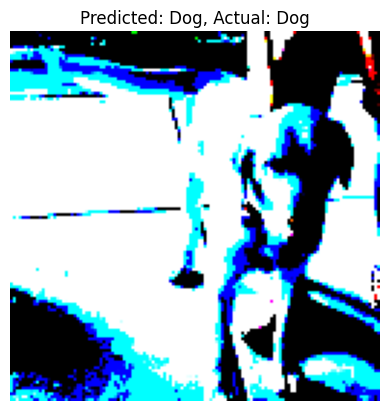

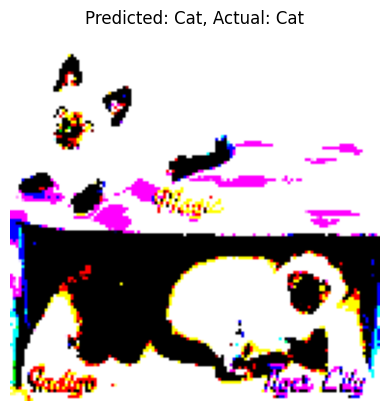

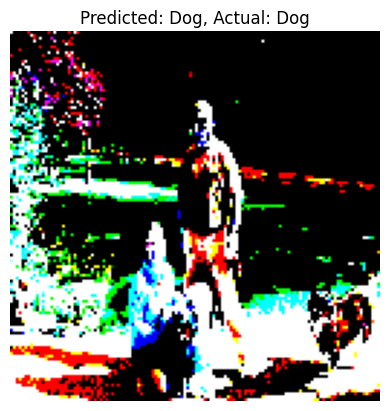

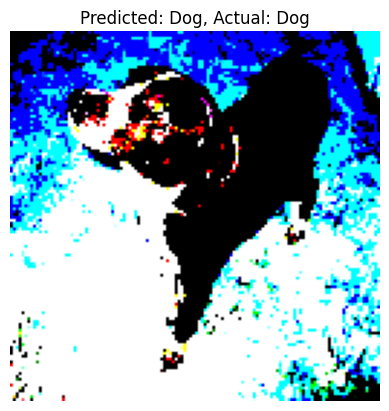

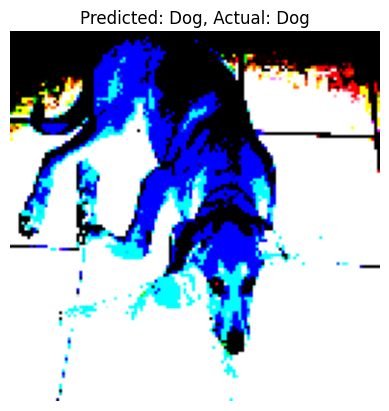

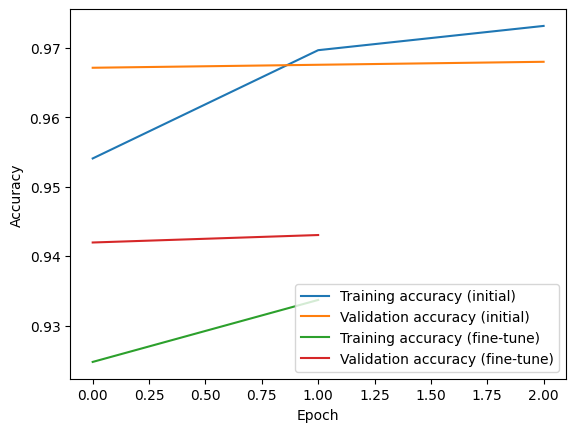

In [46]:
# Plot some predictions with the actual labels
for i in range(5):  # Display first 5 images
    plt.imshow(sample_images[i].numpy())
    pred_label = 'Dog' if predictions_labels[i] == 1 else 'Cat'
    true_label = 'Dog' if sample_labels[i].numpy() == 1 else 'Cat'
    plt.title(f"Predicted: {pred_label}, Actual: {true_label}")
    plt.axis('off')
    plt.show()

# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training accuracy (initial)')
plt.plot(history.history['val_accuracy'], label='Validation accuracy (initial)')
plt.plot(history_fine.history['accuracy'], label='Training accuracy (fine-tune)') # Changed history_finetune to history_fine
plt.plot(history_fine.history['val_accuracy'], label='Validation accuracy (fine-tune)') # Changed history_finetune to history_fine
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()